In [1]:
from pathlib import Path

DATA = Path("../data")      # notebooks/ ‚Üí ../data Î°ú Ïò¨ÎùºÍ∞ÄÍ≤å
(DATA/"raw").mkdir(parents=True, exist_ok=True)
(DATA/"network").mkdir(parents=True, exist_ok=True)
DATA

PosixPath('../data')

In [2]:
import osmnx as ox
print(ox.__version__)

2.0.6


In [3]:
import osmnx as ox, sys, pathlib
print("OSMnx:", ox.__version__)
print("CWD:", pathlib.Path.cwd())

OSMnx: 2.0.6
CWD: /Users/ieunseo/Desktop/adrenaline-proto/notebooks


In [14]:
from pathlib import Path
import pandas as pd
import geopandas as gpd
import osmnx as ox

# --- OSMnx Í∏∞Î≥∏ ÏÑ§Ï†ï ---
ox.settings.log_console = True
ox.settings.use_cache = True

# --- Ï∂úÎ†• Ìè¥Îçî ---
OUT_DIR = Path("./data/network/jeju_walk")
OUT_DIR.mkdir(parents=True, exist_ok=True)

# --- 1) Ï†úÏ£ºÏãú Î≥¥Ìñâ ÎÑ§Ìä∏ÏõåÌÅ¨ ÏàòÏßë ---
G = ox.graph_from_place("Ï†úÏ£ºÏãú, Ï†úÏ£ºÌäπÎ≥ÑÏûêÏπòÎèÑ, ÎåÄÌïúÎØºÍµ≠",
                        network_type="walk",
                        simplify=True)
print("nodes:", len(G.nodes), "edges:", len(G.edges))

# --- 2) GDF Î≥ÄÌôò (edgeÏóê u,v,key Ìè¨Ìï®) ---
nodes_gdf, edges_gdf = ox.graph_to_gdfs(G, nodes=True, edges=True)
# OSMnx Í∏∞Î≥∏ÏùÄ EPSG:4326(WGS84). FMMÏóêÏÑú delta(Í±∞Î¶¨)Îäî 'ÎØ∏ÌÑ∞'Í∞Ä Ìé∏ÌïòÎØÄÎ°ú
# UBODT/FMM ÏûÖÎ†•Ïö© Îç∞Ïù¥ÌÑ∞Îäî 'ÎØ∏ÌÑ∞ Îã®ÏúÑ'Ïùò Ìà¨ÏòÅ Ï¢åÌëúÎ°ú Ï§ÄÎπÑÌïòÎäî Í≤å ÏïàÏ†ÑÌï©ÎãàÎã§.
# Ï†úÏ£º(126.5E, 33.5N)Îäî ÎåÄÎûµ UTM 52N(=EPSG:32652)Ïù¥ Ïûò ÎßûÏäµÎãàÎã§.
edges_wgs84 = edges_gdf.to_crs(epsg=4326)      # ÏãúÍ∞ÅÌôî/GeoJSONÏö©
edges_m     = edges_gdf.to_crs(epsg=32652)     # FMM/UBODTÏö© (ÎØ∏ÌÑ∞)

# --- 3) ÏóÜÎäî Ïª¨ÎüºÏùÑ ÏïàÏ†ïÏ†ÅÏúºÎ°ú Ï∂îÍ∞Ä (KeyError Î∞©ÏßÄ) ---
desired_cols = ["highway", "name", "surface", "foot", "access", "bridge", "tunnel"]
for col in desired_cols:
    if col not in edges_wgs84.columns:
        edges_wgs84[col] = pd.NA
    if col not in edges_m.columns:
        edges_m[col] = pd.NA

# --- 4) ÏãúÍ∞ÅÌôî/ÎîîÎ≤ÑÍπÖÏö© GeoJSON ÎÇ¥Î≥¥ÎÇ¥Í∏∞ (ÏûàÎäî Ïª¨ÎüºÎßå ÏÑ†ÌÉù) ---
safe_cols = ["geometry"] + desired_cols
safe_cols = [c for c in safe_cols if c in edges_wgs84.columns]
edges_wgs84[safe_cols].to_file(OUT_DIR / "pedestrian.geojson", driver="GeoJSON")

# --- 5) FMMÏù¥ ÏöîÍµ¨ÌïòÎäî ÌòïÌÉúÏùò Shapefile ÎßåÎì§Í∏∞ ---
# FMMÏùÄ edge-id, source, target ÌïÑÎìúÍ∞Ä ÌïÑÏöîÌï©ÎãàÎã§.
# graph_to_gdfs Í≤∞Í≥ºÏóêÎäî u,v,key Ïó¥Ïù¥ ÏûàÏúºÎãà Ïù¥Î•º source/targetÏúºÎ°ú Îß§Ìïë,
# idÎäî 0..N-1 Ïó∞ÏÜç Ï†ïÏàòÎ°ú Î∂ÄÏó¨Ìï©ÎãàÎã§.
edges_for_fmm = edges_m.copy()
edges_for_fmm = edges_for_fmm.reset_index()   # u,v,keyÍ∞Ä Ïù∏Îç±Ïä§->Ïó¥Î°ú ÎÇ¥Î†§Ïò§Í≤å
# ÌòπÏãú Ïù¥ÎØ∏ 'u','v'Í∞Ä Ïó¥Ïóê ÏóÜÎã§Î©¥ Îã§Ïùå Ï§ÑÏù¥ ÌïÑÏöî ÏóÜÏßÄÎßå, ÏùºÎ∞òÏ†ÅÏúºÎ°úÎäî ÌïÑÏöîÌï©ÎãàÎã§.

# ÌïÑÏàò ÌïÑÎìú Íµ¨ÏÑ±
edges_for_fmm["id"] = range(len(edges_for_fmm))
edges_for_fmm = edges_for_fmm.rename(columns={"u": "source", "v": "target"})

# FMMÏùÄ Îã®ÏàúÌïú ÏÜçÏÑ±Îßå ÌïÑÏöîÌïòÎØÄÎ°ú Íº≠ ÌïÑÏöîÌïú ÌïÑÎìúÎßå ÎÇ®ÍπÅÎãàÎã§.
# (geometryÎäî EPSG:32652Î°ú 'ÎØ∏ÌÑ∞' Îã®ÏúÑ)
fmm_cols = ["id", "source", "target", "geometry"]
edges_uv = edges_for_fmm[fmm_cols]

# --- 6) Ï†ÄÏû• ÌòïÏãù Ï£ºÏùò ---
# ShapefileÏùÄ ÌïÑÎìúÎ™Ö Í∏∏Ïù¥/Î¨∏ÏûêÏó¥ Í∏∏Ïù¥ Ï†úÌïúÏù¥ ÎßéÏïÑ Í≤ΩÍ≥†Í∞Ä ÎúπÎãàÎã§.
# FMMÏù¥ Íº≠ ShapefileÏùÑ ÏöîÍµ¨ÌïòÏßÄ ÏïäÏúºÎ©¥ GeoPackage(.gpkg)Î•º Í∂åÏû•Ìï©ÎãàÎã§.
# Í∑∏ÎûòÎèÑ ShapefileÏù¥ ÌïÑÏöîÌïòÎ©¥ ÏïÑÎûòÏ≤òÎüº Ï†ÄÏû•ÌïòÎ©¥ Îê©ÎãàÎã§.
edges_uv.to_file(OUT_DIR / "edges_uv.shp")                 # FMM ÏûÖÎ†•Ïö©
edges_wgs84.to_file(OUT_DIR / "edges.shp")                 # Î†àÌçºÎü∞Ïä§
nodes_gdf.to_crs(epsg=4326).to_file(OUT_DIR / "nodes.shp") # Î†àÌçºÎü∞Ïä§

# GeoPackage(Í∂åÏû•)ÎèÑ Ìï®Íªò Ï†ÄÏû• (ÌïÑÎìú Ï†úÌïú Ï†ÅÍ≥† ÏïàÏ†ïÏ†Å)
edges_uv.to_file(OUT_DIR / "edges_uv.gpkg", layer="edges_uv", driver="GPKG")

# --- 7) Í∑∏ÎûòÌîÑMLÎèÑ Î≥¥Í¥Ä (ÎîîÎ≤ÑÍπÖ/Ïû¨ÏÇ¨Ïö©Ïö©) ---
graphml_path = OUT_DIR / "jeju_walk.graphml"
if hasattr(ox, "save_graphml"):
    ox.save_graphml(G, filepath=str(graphml_path))
else:
    ox.io.save_graphml(G, filepath=str(graphml_path))

print("Saved to:", OUT_DIR.resolve())


nodes: 23071 edges: 66404


/opt/anaconda3/envs/adrenaline-proto/lib/python3.10/site-packages/pyogrio/raw.py:723: RuntimeWarning: Value '[369907074, 369907075, 369907076, 369907077, 369907078, 369151748, 369155753, 369155757, 369155758, 369155759, 369155760, 369155761, 369155762, 369155763, 369155764, 369155765, 369155766, 369155767, 369155768, 369155769, 369907782, 369907788, 372845796, 369907051]' of field osmid has been truncated to 254 characters.  This warning will not be emitted any more for that layer.
  ogr_write(
/var/folders/xg/n07cc3254sdcw3q71k1w0j880000gn/T/ipykernel_5329/1610119323.py:64: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  nodes_gdf.to_crs(epsg=4326).to_file(OUT_DIR / "nodes.shp") # Î†àÌçºÎü∞Ïä§
/opt/anaconda3/envs/adrenaline-proto/lib/python3.10/site-packages/pyogrio/raw.py:723: RuntimeWarning: Normalized/laundered field name: 'street_count' to 'street_cou'
  ogr_write(


Saved to: /Users/ieunseo/Desktop/adrenaline-proto/notebooks/data/network/jeju_walk


In [16]:
from pathlib import Path
import osmnx as ox
import geopandas as gpd

# 1) Í∑∏ÎûòÌîÑ ‚Üí GDF
G = ox.graph_from_place("Ï†úÏ£ºÏãú, Ï†úÏ£ºÌäπÎ≥ÑÏûêÏπòÎèÑ, ÎåÄÌïúÎØºÍµ≠", network_type="walk", simplify=True)
nodes_gdf, edges_gdf = ox.graph_to_gdfs(G, nodes=True, edges=True)
edges_gdf = edges_gdf.to_crs(epsg=4326)

# 2) ÌïÑÏöîÌïú Ïª¨ÎüºÏª¨Îüº Î≥¥Ï†ï: ÏóÜÏúºÎ©¥ Ï∂îÍ∞Ä
wanted = ["highway","name","surface","foot","access","bridge","tunnel"]
for c in wanted:
    if c not in edges_gdf.columns:
        edges_gdf[c] = None

# 3) shape_type Ï∂îÍ∞Ä
edges_gdf["shape_type"] = edges_gdf.geometry.geom_type

# 4) Ï†ÄÏû•
OUT_DIR = Path("./data/network/jeju_walk"); OUT_DIR.mkdir(parents=True, exist_ok=True)
keep_cols = ["geometry"] + wanted + ["shape_type"]
edges_gdf[keep_cols].to_file(OUT_DIR / "pedestrian.geojson", driver="GeoJSON")

# (ÏÑ†ÌÉù) ShapefileÎèÑ Ï†ÄÏû•
nodes_gdf.to_file(OUT_DIR / "nodes.shp")
edges_gdf.to_file(OUT_DIR / "edges.shp")

# (ÏÑ†ÌÉù) GraphML
ox.save_graphml(G, filepath=str(OUT_DIR / "jeju_walk.graphml"))

print("Ï†ÄÏû•Îê®:", list(OUT_DIR.glob("*")))


/var/folders/xg/n07cc3254sdcw3q71k1w0j880000gn/T/ipykernel_5329/3334144701.py:25: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  nodes_gdf.to_file(OUT_DIR / "nodes.shp")
/opt/anaconda3/envs/adrenaline-proto/lib/python3.10/site-packages/pyogrio/raw.py:723: RuntimeWarning: Normalized/laundered field name: 'street_count' to 'street_cou'
  ogr_write(
/opt/anaconda3/envs/adrenaline-proto/lib/python3.10/site-packages/pyogrio/raw.py:723: RuntimeWarning: Value '[369907074, 369907075, 369907076, 369907077, 369907078, 369151748, 369155753, 369155757, 369155758, 369155759, 369155760, 369155761, 369155762, 369155763, 369155764, 369155765, 369155766, 369155767, 369155768, 369155769, 369907782, 369907788, 372845796, 369907051]' of field osmid has been truncated to 254 characters.  This warning will not be emitted any more for that layer.
  ogr_write(


Ï†ÄÏû•Îê®: [PosixPath('data/network/jeju_walk/pedestrian.geojson'), PosixPath('data/network/jeju_walk/edges_uv.shp'), PosixPath('data/network/jeju_walk/edges_uv.cpg'), PosixPath('data/network/jeju_walk/edges_uv.shx'), PosixPath('data/network/jeju_walk/edges.dbf'), PosixPath('data/network/jeju_walk/nodes.prj'), PosixPath('data/network/jeju_walk/edges.shp'), PosixPath('data/network/jeju_walk/edges.cpg'), PosixPath('data/network/jeju_walk/edges.shx'), PosixPath('data/network/jeju_walk/edges_uv.dbf'), PosixPath('data/network/jeju_walk/jeju_walk.graphml'), PosixPath('data/network/jeju_walk/edges_uv.prj'), PosixPath('data/network/jeju_walk/nodes.shx'), PosixPath('data/network/jeju_walk/nodes.shp'), PosixPath('data/network/jeju_walk/nodes.cpg'), PosixPath('data/network/jeju_walk/edges.prj'), PosixPath('data/network/jeju_walk/nodes.dbf'), PosixPath('data/network/jeju_walk/edges_uv.gpkg')]


In [18]:
import geopandas as gpd
gdf = gpd.read_file("data/network/jeju_walk/pedestrian.geojson")
gdf.head()

Skipping field highway: unsupported OGR type: 5
Skipping field name: unsupported OGR type: 5


u            v  key surface  foot access bridge tunnel  shape_type  \
0  414679035   2823930336    0    None  None   None   None   None  LineString   
1  414679035   2823956648    0    None  None   None   None   None  LineString   
2  414679035   2808553838    0    None  None   None   None   None  LineString   
3  414679035   2823956693    0    None  None   None   None   None  LineString   
4  414679037  12709535501    0    None  None   None   None   None  LineString   

                                            geometry  
0  LINESTRING (126.26934 33.40488, 126.26941 33.4...  
1  LINESTRING (126.26934 33.40488, 126.26923 33.4...  
2  LINESTRING (126.26934 33.40488, 126.26945 33.4...  
3  LINESTRING (126.26934 33.40488, 126.26928 33.4...  
4  LINESTRING (126.2636 33.3987, 126.26358 33.39897)

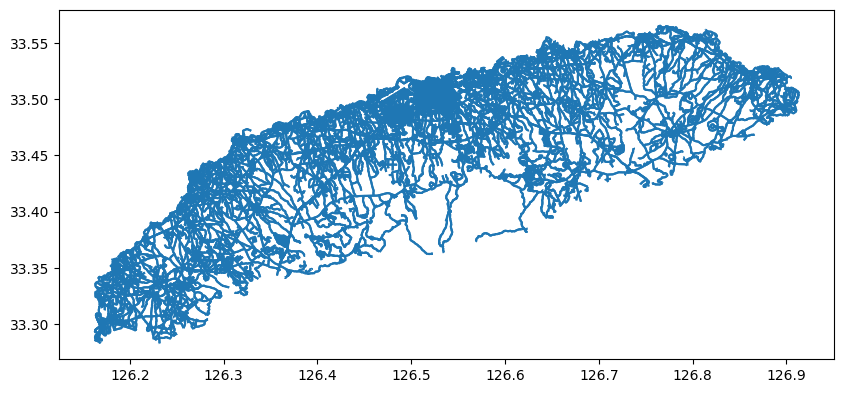

In [20]:
import matplotlib.pyplot as plt
gdf.plot(figsize=(10,10))
plt.show()

In [22]:
from svgpathtools import svg2paths2
import numpy as np
from shapely.geometry import LineString, MultiLineString
import geopandas as gpd
from pathlib import Path
from math import cos, radians

def svg_to_lines(svg_path: str,
                 samples_per_path: int = 400,
                 use_subpaths: bool = True,
                 flip_y: bool = True):
    """
    SVGÏùò pathÎì§ÏùÑ ÏÉòÌîåÎßÅÌïòÏó¨ ÌôîÎ©¥Ï¢åÌëú(x,y) Ìè¥Î¶¨ÎùºÏù∏ Î¶¨Ïä§Ìä∏Î°ú Î∞òÌôò
    - viewBoxÎ°ú Ï†ïÍ∑úÌôîÌïòÏó¨ (0~1) Î≤îÏúÑÎ°ú ÎßûÏ∂ò Îí§ Î∞òÌôò
    - flip_y=TrueÎ©¥ SVG Ïä§ÌÅ¨Î¶∞ Ï¢åÌëúÍ≥Ñ(y‚Üì)Î•º ÏàòÌïôÏ¢åÌëúÍ≥Ñ(y‚Üë)Î°ú Îí§ÏßëÏùå
    """
    paths, attrs, svg_attrs = svg2paths2(svg_path)
    vb = svg_attrs.get("viewBox", None)
    if vb:
        x0, y0, w, h = map(float, vb.split())
    else:
        # viewBoxÍ∞Ä ÏóÜÏúºÎ©¥ width/height ÏÇ¨Ïö© (px)
        w = float(svg_attrs.get("width", 1))
        h = float(svg_attrs.get("height", 1))
        x0, y0 = 0.0, 0.0

    lines = []
    for p in paths:
        # pathÎ•º Íµ¨ÏÑ±ÌïòÎäî Ïó∞ÏÜç Íµ¨Í∞ÑÎì§ÏùÑ Í∞úÎ≥Ñ polylineÏúºÎ°ú
        subpaths = p.continuous_subpaths() if use_subpaths else [p]
        for sp in subpaths:
            ts = np.linspace(0, 1, samples_per_path)
            xy = np.array([[complex(sp.point(t)).real, complex(sp.point(t)).imag] for t in ts])

            # viewBox Í∏∞Ï§Ä Ï†ïÍ∑úÌôî (0~1)
            x = (xy[:,0] - x0) / w
            y = (xy[:,1] - y0) / h
            if flip_y:  # ÌôîÎ©¥ yÏ∂ï ÏïÑÎûòÎ∞©Ìñ• ‚Üí ÏàòÌïôÏ¢åÌëúÍ≥Ñ ÏúÑÏ™Ω
                y = 1 - y

            # 0~1 Î≤îÏúÑ ÎùºÏù∏ÏùÑ LineStringÏúºÎ°ú
            line = LineString(np.column_stack([x, y]))
            if not line.is_empty:
                lines.append(line)

    if not lines:
        return None
    return MultiLineString(lines) if len(lines) > 1 else lines[0]


In [24]:
def normalized_to_wgs84(geom,
                        lon0: float, lat0: float,
                        size_m: float = 1000.0,
                        rotation_deg: float = 0.0):
    """
    (0~1) Ï†ïÍ∑úÌôî Ï¢åÌëúÎ•º Ï§ëÏã¨(lon0,lat0) Ï£ºÎ≥ÄÏóê 'size_m' ÌÅ¨Í∏∞Î°ú Î∞∞ÏπòÌïú WGS84 LineString/MultiLineString Î∞òÌôò
    - size_m: ÎèÑÌòïÏùò Í∞ÄÎ°ú/ÏÑ∏Î°ú ÌèâÍ∑† ÌÅ¨Í∏∞(ÎØ∏ÌÑ∞). Ï†ïÏÇ¨Í∞ÅÌòïÏúºÎ°ú Í∞ÄÏ†ï
    - rotation_deg: ÏãúÍ≥Ñ Î∞òÎåÄ(+)
    """
    # Ï§ëÏã¨ Í∏∞Ï§Ä [-0.5, 0.5]Î°ú Ïù¥Îèô
    def _to_xy(arr):
        # arr: (N,2) in [0,1]
        xy = arr - 0.5  # Ï§ëÏã¨Ìôî
        # ÌöåÏ†Ñ
        th = radians(rotation_deg)
        R = np.array([[np.cos(th), -np.sin(th)],
                      [np.sin(th),  np.cos(th)]])
        xy = xy @ R.T
        # ÎØ∏ÌÑ∞ Ïä§ÏºÄÏùº
        # ÏúÑÎèÑ 1ÎèÑ ‚âà 111_320 m, Í≤ΩÎèÑ 1ÎèÑ ‚âà 111_320 * cos(lat)
        m_per_deg_lat = 111_320.0
        m_per_deg_lon = 111_320.0 * cos(radians(lat0))
        # size_mÍ∞Ä Ï†ÑÏ≤¥ Ìè≠(=1.0)Ïóê Ìï¥ÎãπÌïòÎèÑÎ°ù Ïä§ÏºÄÏùº
        sx_deg = (size_m / m_per_deg_lon)
        sy_deg = (size_m / m_per_deg_lat)
        lon = lon0 + xy[:,0] * sx_deg
        lat = lat0 + xy[:,1] * sy_deg
        return np.column_stack([lon, lat])

    if isinstance(geom, LineString):
        arr = np.array(geom.coords)
        return LineString(_to_xy(arr))
    elif isinstance(geom, MultiLineString):
        return MultiLineString([LineString(_to_xy(np.array(ls.coords))) for ls in geom.geoms])
    else:
        raise TypeError("LineString/MultiLineStringÎßå ÏßÄÏõêÌï©ÎãàÎã§.")


In [28]:
# ÏûÖÎ†•/Ï∂úÎ†• Í≤ΩÎ°ú
SVG = "../data/templates/star.svg"      # ‚Üê ÎÑ§ SVG Í≤ΩÎ°úÎ°ú Î∞îÍøîÏ§ò
OUT_DIR = Path("../data/templates"); OUT_DIR.mkdir(parents=True, exist_ok=True)
OUT_GJ = OUT_DIR / "star.geojson"

# 3-1) SVGÎ•º Ìè¥Î¶¨ÎùºÏù∏ÏúºÎ°ú
geom_norm = svg_to_lines(SVG, samples_per_path=600, use_subpaths=True, flip_y=True)

# 3-2) Ï†úÏ£ºÏãú Ï£ºÎ≥ÄÏóê Î∞∞Ïπò (Ï§ëÏã¨/ÌÅ¨Í∏∞/ÌöåÏ†Ñ Ï°∞Ï†à Í∞ÄÎä•)
# Ï†úÏ£ºÎåÄÌïôÍµê Í≥µÍ≥ºÎåÄÌïô 4Ìò∏Í¥Ä Ï¢åÌëú
lon0, lat0 = 126.564018, 33.452345   # Í≥µÎåÄ4Ìò∏Í¥Ä Ï§ëÏã¨

geom_wgs = normalized_to_wgs84(
    geom_norm,
    lon0=126.564018,
    lat0=33.452345,
    size_m=3000,        # 8km Îõ∞Í∏∞ Î™©Ìëú -> Ïã§Ï†ú ÌÅ¨Í∏∞ Ï°∞Ï†à Ìè¨Ïù∏Ìä∏ 
    rotation_deg=0 #ÌïÑÏöîÌïú Í≤ΩÏö∞ Í∞ÅÎèÑ Ï°∞Ï†ï
)

gdf = gpd.GeoDataFrame({"name": ["star"]}, geometry=[geom_wgs], crs="EPSG:4326")
gdf.to_file(OUT_GJ, driver="GeoJSON")

In [50]:
#star.geojsonÏùÄ ÏÑ†(LineString) ÌïòÎÇòÎãàÍπå, Ïù¥Í±∏ Îì±Í∞ÑÍ≤© Ï†êÎì§Î°ú Î∂ÑÌï†Ìïú ÌõÑ ‚Üí id,lon,lat,timestamp CSVÎ°ú
import geopandas as gpd
import pandas as pd
from shapely.geometry import LineString
import numpy as np

# ÏûÖÎ†• Î∞è Ï∂úÎ†• ÌååÏùº
GEOJSON = "../data/templates/star.geojson"
CSV_OUT = "../data/network/jeju_walk/gps_star.csv"  # FMMÏóêÏÑú Ï∞∏Ï°∞Ìïú Í≤ΩÎ°úÎ°ú Ï†ÄÏû•

# Î™á Í∞úÏùò Ï†êÏúºÎ°ú ÏÉòÌîåÎßÅÌï†ÏßÄ ÏÑ§Ï†ï
NUM_POINTS = 300

# GeoJSON Î°úÎìú
gdf = gpd.read_file(GEOJSON)
line: LineString = gdf.geometry[0]

# Îì±Í∞ÑÍ≤© Ìè¨Ïù∏Ìä∏ ÏÉòÌîåÎßÅ
distances = np.linspace(0, line.length, NUM_POINTS)
points = [line.interpolate(d) for d in distances]

# CSVÏö© Îç∞Ïù¥ÌÑ∞ÌîÑÎ†àÏûÑ ÏÉùÏÑ±
df = pd.DataFrame({
    "id": ["star"] * NUM_POINTS,
    "lon": [p.x for p in points],
    "lat": [p.y for p in points],
    "timestamp": pd.date_range(start="2025-01-01", periods=NUM_POINTS, freq="1s").astype(str)
})

# Ï†ÄÏû•
df.to_csv(CSV_OUT, index=False)
print(f"‚úÖ Saved: {CSV_OUT}")


‚úÖ Saved: ../data/network/jeju_walk/gps_star.csv


In [34]:
import osmnx as ox
import geopandas as gpd
import numpy as np
from shapely.ops import nearest_points
from pathlib import Path

# --- Ï¢åÌëúÍ≥Ñ Ï†ïÏùò ---
CRS_WGS84 = "EPSG:4326"
CRS_METRIC = "EPSG:32652"   # Ï†úÏ£ºÎèÑ UTM Zone 52N (ÎØ∏ÌÑ∞ Îã®ÏúÑ)

# --- 1. ÎèÑÎ≥¥ ÎÑ§Ìä∏ÏõåÌÅ¨ Î°úÎî© ---
G = ox.load_graphml("../data/network/jeju_walk/jeju_walk.graphml")
nodes, edges = ox.graph_to_gdfs(G)

# Í±∞Î¶¨ Ïó∞ÏÇ∞ÏùÑ ÏúÑÌï¥ EPSG:32652Î°ú Î≥ÄÌôò
nodes_proj = nodes.to_crs(CRS_METRIC)
edges_proj = edges.to_crs(CRS_METRIC)

# --- 2. ÌÖúÌîåÎ¶ø GeoJSON Î°úÎî© (Î≥Ñ Í∂§Ï†Å) ---
template = gpd.read_file("../data/templates/star.geojson")
template_proj = template.to_crs(CRS_METRIC)
template_line = template_proj.geometry.iloc[0]  # Îã®Ïùº Í∂§Ï†Å ÏÑ†(LineString)

# --- 3. ÎÖ∏ÎìúÎ°ú Ïä§ÎÉÖÌïëÌïòÎäî Ìï®Ïàò ---
def snap_to_nearest_nodes(line, nodes_gdf, n_points=100):
    # ÎùºÏù∏ ÏúÑÏóêÏÑú ÏùºÏ†ï Í∞ÑÍ≤©ÏúºÎ°ú ÏÉòÌîå Ìè¨Ïù∏Ìä∏ ÏÉùÏÑ±
    distances = np.linspace(0, line.length, n_points)
    points = [line.interpolate(d) for d in distances]

    snapped_ids = []
    for pt in points:
        # Í∞Å Ìè¨Ïù∏Ìä∏Ïóê ÎåÄÌï¥ Í∞ÄÏû• Í∞ÄÍπåÏö¥ ÎÖ∏ÎìúÏùò index Ï∞æÍ∏∞
        nearest_id = nodes_gdf.distance(pt).idxmin()  #node ID!
        snapped_ids.append(nearest_id)

    return snapped_ids

# --- 4. ÎÖ∏Îìú ÏãúÌÄÄÏä§ Ï∂îÏ∂ú (Ïòà: 100Í∞ú ÏßÄÏ†ê) ---
snapped_ids = snap_to_nearest_nodes(template_line, nodes_proj, n_points=100)

# --- 5. ÌôïÏù∏ Ï∂úÎ†• ---
print("üîπ Ïä§ÎÉÖÎêú ÎÖ∏Îìú ID (ÏùºÎ∂Ä):", snapped_ids[:10])
print("üîπ Ï†ÑÏ≤¥ Í∞úÏàò:", len(snapped_ids))


üîπ Ïä§ÎÉÖÎêú ÎÖ∏Îìú ID (ÏùºÎ∂Ä): [np.int64(2897246463), np.int64(2897246463), np.int64(2294871471), np.int64(2294871471), np.int64(2294871471), np.int64(3734263322), np.int64(4631888080), np.int64(5325388740), np.int64(3740489760), np.int64(3740489760)]
üîπ Ï†ÑÏ≤¥ Í∞úÏàò: 100


In [36]:
import geopandas as gpd
from pathlib import Path

# edges: ox.graph_to_gdfs(G)Î°ú ÏñªÏùÄ Ïó£ÏßÄ GDFÎùºÍ≥† Í∞ÄÏ†ï
# 1) Ïù∏Îç±Ïä§(u,v,key)Î•º Ïª¨ÎüºÏúºÎ°ú ÎπºÏò§Í∏∞
edges_cols = edges.reset_index()  # ‚òÖ drop Ïì∞ÏßÄ ÎßàÏÑ∏Ïöî

# 2) FMMÏù¥ ÏöîÍµ¨ÌïòÎäî Ïª¨Îüº Íµ¨ÏÑ± (source/target/id/geometry)
edges_fmm = edges_cols.rename(columns={"u": "source", "v": "target"}).copy()
edges_fmm["id"] = edges_fmm.index.astype(int)

# 3) (Í∂åÏû•) Ï¢åÌëúÍ≥Ñ WGS84 ÌôïÏù∏/Î≥ÄÌôò
edges_fmm = edges_fmm.to_crs(epsg=4326)

# 4) Ï†ÄÏû•
out = Path("../data/network/jeju_walk"); out.mkdir(parents=True, exist_ok=True)
edges_fmm[["id", "source", "target", "geometry"]].to_file(out / "edges_uv.shp")

print("saved:", (out / "edges_uv.shp").resolve())
print(edges_fmm[["id","source","target"]].head())


saved: /Users/ieunseo/Desktop/adrenaline-proto/data/network/jeju_walk/edges_uv.shp
   id     source       target
0   0  414679035   2823930336
1   1  414679035   2823956648
2   2  414679035   2808553838
3   3  414679035   2823956693
4   4  414679037  12709535501


In [38]:
import geopandas as gpd
from pathlib import Path

# 1. ÌååÏùº Í≤ΩÎ°ú ÏÑ§Ï†ï
TEMPLATE_PATH = Path("../data/templates/star.geojson")
EDGES_PATH = Path("../data/network/jeju_walk/edges_uv.shp")
CLIPPED_PATH = Path("../data/network/jeju_walk/edges_uv_clipped.shp")

# 2. Í∂§Ï†Å (Î≥Ñ) Î°úÎî© ‚Üí ÎØ∏ÌÑ∞ Ï¢åÌëúÍ≥ÑÎ°ú Î≥ÄÌôò
template = gpd.read_file(TEMPLATE_PATH).to_crs(epsg=32652)
template_buffer = template.buffer(800)  # ‚Üê 800m Î∞òÍ≤ΩÏúºÎ°ú ÎèÑÎ°úÎßù ÏûêÎ•¥Í∏∞

# 3. ÎèÑÎ°úÎßù Î°úÎî© ‚Üí Í∞ôÏùÄ Ï¢åÌëúÍ≥Ñ
edges = gpd.read_file(EDGES_PATH).to_crs(epsg=32652)

# 4. Î≥Ñ Ï£ºÎ≥ÄÎßå ÎÇ®Í∏∞Í∏∞
clipped = edges[edges.intersects(template_buffer.unary_union)].copy()

# 5. Ï†ÄÏû• (WGS84Î°ú Îã§Ïãú Î≥ÄÌôò ÌõÑ Ï†ÄÏû•)
clipped = clipped.to_crs(epsg=4326)
clipped.to_file(CLIPPED_PATH)
print(f"‚úÖ ÌÅ¥Î¶Ω ÏôÑÎ£å! {len(clipped)}Í∞ú Ïó£ÏßÄÍ∞Ä Ï†ÄÏû•Îê®:", CLIPPED_PATH.resolve())


‚úÖ ÌÅ¥Î¶Ω ÏôÑÎ£å! 1146Í∞ú Ïó£ÏßÄÍ∞Ä Ï†ÄÏû•Îê®: /Users/ieunseo/Desktop/adrenaline-proto/data/network/jeju_walk/edges_uv_clipped.shp


/var/folders/xg/n07cc3254sdcw3q71k1w0j880000gn/T/ipykernel_5329/1642591283.py:17: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  clipped = edges[edges.intersects(template_buffer.unary_union)].copy()


In [42]:
import pandas as pd

df = pd.read_csv("../data/network/jeju_walk/gps_star.csv")

# WKT ÌòïÌÉúÏùò POINT Ïª¨Îüº Ï∂îÍ∞Ä
df["geom"] = df.apply(lambda r: f"POINT({r['lon']} {r['lat']})", axis=1)

df.to_csv("../data/network/jeju_walk/gps_star.csv", index=False)
print("‚úÖ geom Ïª¨Îüº Ï∂îÍ∞Ä ÏôÑÎ£å")


‚úÖ geom Ïª¨Îüº Ï∂îÍ∞Ä ÏôÑÎ£å


In [56]:
import pandas as pd
import geopandas as gpd
from shapely import wkt
from shapely.geometry import LineString

# Ï†àÎåÄ Í≤ΩÎ°ú ÏÇ¨Ïö©
BASE = "/Users/ieunseo/Desktop/adrenaline-proto"  # Î≥∏Ïù∏ Í≤ΩÎ°úÎ°ú ÏàòÏ†ï
csv_path = f"{BASE}/data/network/jeju_walk/gps_star.csv"
output_path = f"{BASE}/data/network/jeju_walk/gps_star_trajectory.shp"

# CSV ÏùΩÍ∏∞
gps = pd.read_csv(csv_path)

# WKT ‚Üí Point Î≥ÄÌôò
gps['geometry'] = gps['geom'].apply(wkt.loads)

# Trajectory ÏÉùÏÑ±
trajectories = []
for traj_id, group in gps.groupby('id'):
    coords = [(p.x, p.y) for p in group['geometry']]
    line = LineString(coords)
    trajectories.append({'id': traj_id, 'geometry': line})

# Ï†ÄÏû•
gdf_traj = gpd.GeoDataFrame(trajectories, crs="EPSG:4326")
gdf_traj.to_file(output_path)

print(f"‚úÖ Saved to: {output_path}")
print(f"   Trajectories: {len(trajectories)}")

KeyError: 'geom'

In [58]:
import pandas as pd

BASE = "/Users/ieunseo/Desktop/adrenaline-proto"
csv_path = f"{BASE}/data/network/jeju_walk/gps_star.csv"

# CSV ÏùΩÍ∏∞
gps = pd.read_csv(csv_path)

# Íµ¨Ï°∞ ÌôïÏù∏
print("Columns:", list(gps.columns))
print("\nFirst 3 rows:")
print(gps.head(3))
print("\nData types:")
print(gps.dtypes)

Columns: ['id', 'lon', 'lat', 'timestamp']

First 3 rows:
     id         lon        lat            timestamp
0  star  126.567205  33.455506  2025-01-01 00:00:00
1  star  126.567352  33.455215  2025-01-01 00:00:01
2  star  126.567691  33.455215  2025-01-01 00:00:02

Data types:
id            object
lon          float64
lat          float64
timestamp     object
dtype: object


In [60]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point, LineString

BASE = "/Users/ieunseo/Desktop/adrenaline-proto"
csv_path = f"{BASE}/data/network/jeju_walk/gps_star.csv"
output_path = f"{BASE}/data/network/jeju_walk/gps_star_trajectory.shp"

# CSV ÏùΩÍ∏∞
gps = pd.read_csv(csv_path)

print(f"‚úÖ CSV loaded: {len(gps)} rows")

# timestamp ÏàúÏÑúÎ°ú Ï†ïÎ†¨ (Ï§ëÏöî!)
gps = gps.sort_values(['id', 'timestamp'])

# idÎ≥ÑÎ°ú Í∑∏Î£πÌôîÌïòÏó¨ LineString ÏÉùÏÑ±
trajectories = []
for traj_id, group in gps.groupby('id'):
    coords = list(zip(group['lon'], group['lat']))
    line = LineString(coords)
    trajectories.append({
        'id': traj_id,
        'geometry': line
    })

# GeoDataFrame ÏÉùÏÑ± Î∞è Ï†ÄÏû•
gdf_traj = gpd.GeoDataFrame(trajectories, crs="EPSG:4326")
gdf_traj.to_file(output_path)

print(f"\n‚úÖ Trajectory Shapefile ÏÉùÏÑ± ÏôÑÎ£å!")
print(f"   File: {output_path}")
print(f"   Trajectories: {len(trajectories)}")
print(f"   Total points: {len(gps)}")
print(f"   Bounds: {gdf_traj.total_bounds}")

# Í±∞Î¶¨ Í≥ÑÏÇ∞ (Ï∞∏Í≥†Ïö©)
line_length_deg = gdf_traj.geometry.iloc[0].length
line_length_km = line_length_deg * 111
print(f"   Total distance: ~{line_length_km:.2f} km")

‚úÖ CSV loaded: 300 rows

‚úÖ Trajectory Shapefile ÏÉùÏÑ± ÏôÑÎ£å!
   File: /Users/ieunseo/Desktop/adrenaline-proto/data/network/jeju_walk/gps_star_trajectory.shp
   Trajectories: 1
   Total points: 300
   Bounds: [126.55017077  33.44037985 126.57786823  33.4644542 ]
   Total distance: ~11.19 km


Matched columns: ['id', 'cpath', 'mgeom']

First row:
   id                                              cpath  \
0   0  11429,28616,43082,31570,42977,28614,28610,1179...   

                                               mgeom  
0  LINESTRING(126.566906252 33.4554961986,126.566...  

‚úÖ Saved to: /Users/ieunseo/Desktop/adrenaline-proto/data/network/jeju_walk/matched_result.png


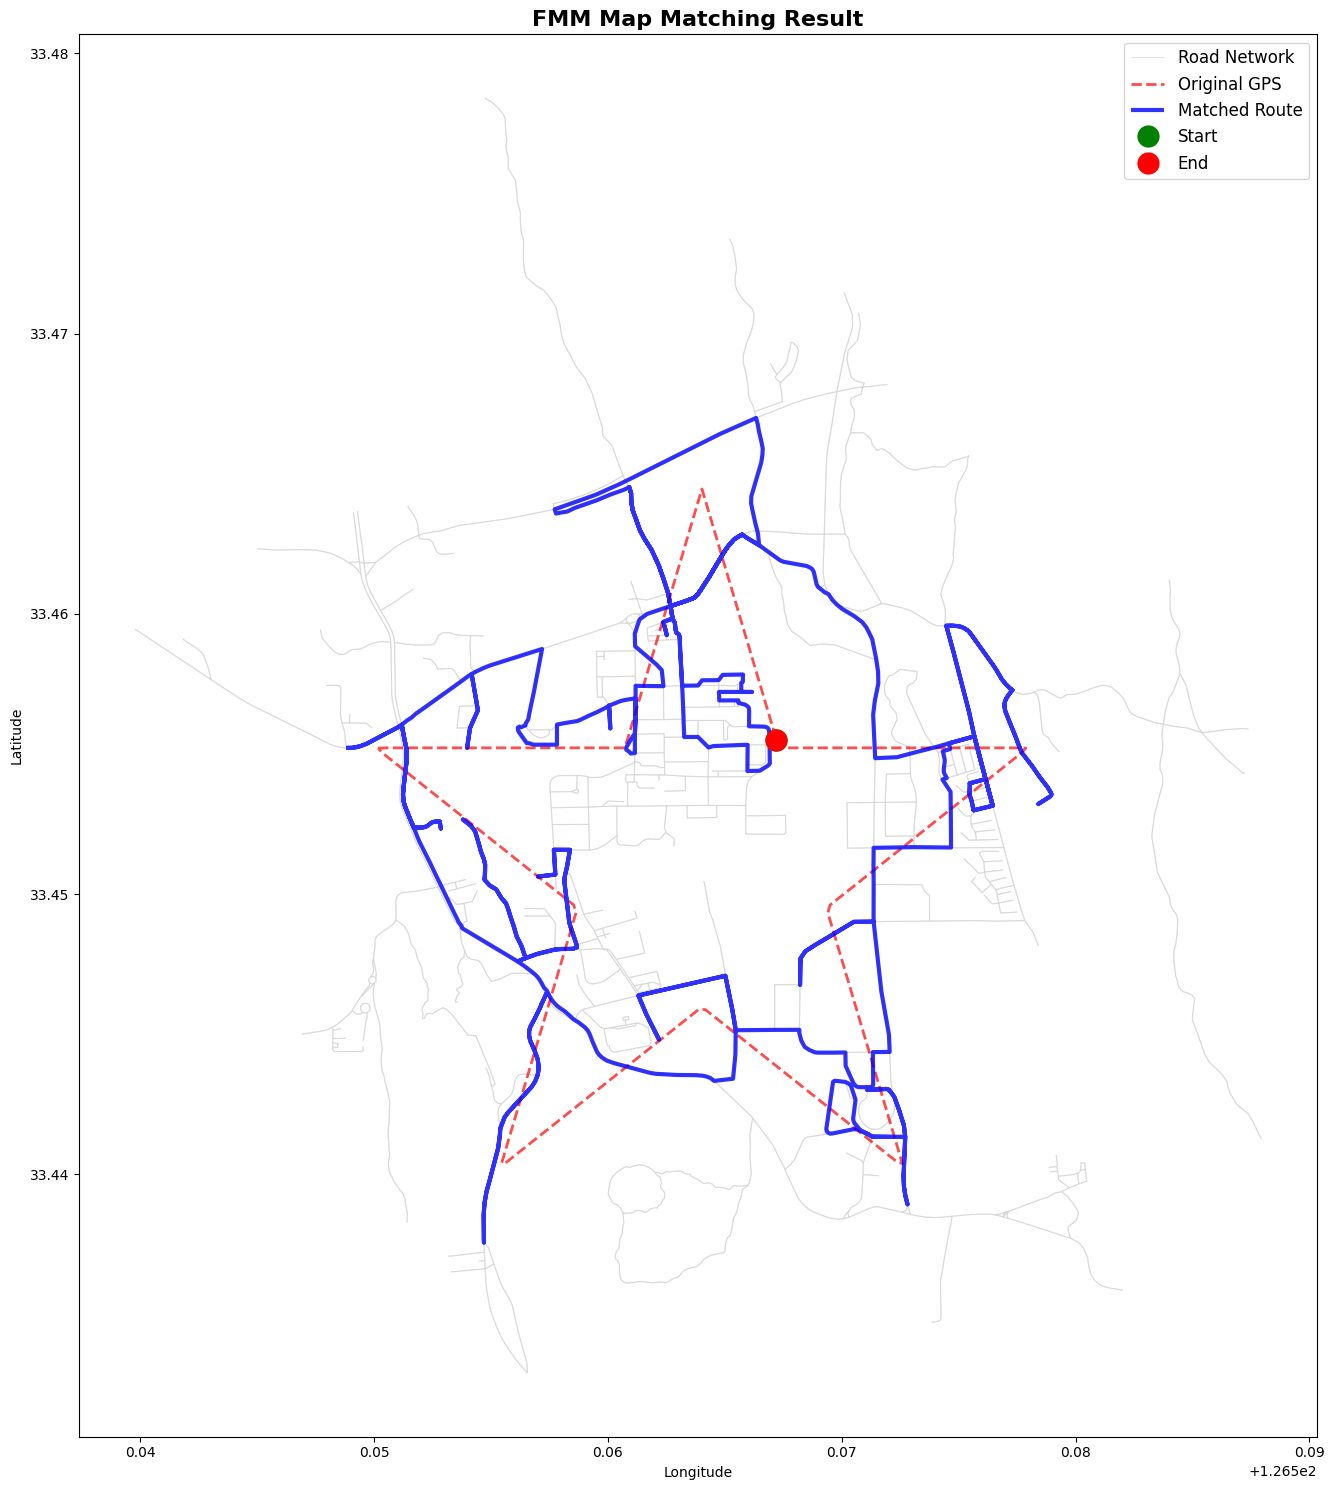

In [62]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely import wkt

BASE = "/Users/ieunseo/Desktop/adrenaline-proto"

# Îß§Ïπ≠ Í≤∞Í≥º ÏùΩÍ∏∞
matched = pd.read_csv(f"{BASE}/data/network/jeju_walk/matched.csv", 
                      delimiter=';')  # FMMÏùÄ ÏÑ∏ÎØ∏ÏΩúÎ°† Íµ¨Î∂ÑÏûê ÏÇ¨Ïö©

print("Matched columns:", list(matched.columns))
print("\nFirst row:")
print(matched.head(1))

# mgeom Ïª¨ÎüºÏùÑ geometryÎ°ú Î≥ÄÌôò
matched['geometry'] = matched['mgeom'].apply(wkt.loads)
gdf_matched = gpd.GeoDataFrame(matched, geometry='geometry', crs="EPSG:4326")

# ÎèÑÎ°úÎßù ÏùΩÍ∏∞
network = gpd.read_file(f"{BASE}/data/network/jeju_walk/edges_uv_clipped.shp")

# ÏõêÎ≥∏ GPS Í∂§Ï†Å ÏùΩÍ∏∞
gps_traj = gpd.read_file(f"{BASE}/data/network/jeju_walk/gps_star_trajectory.shp")

# ÏãúÍ∞ÅÌôî
fig, ax = plt.subplots(figsize=(15, 15))

# 1. ÎèÑÎ°úÎßù (ÌöåÏÉâ)
network.plot(ax=ax, color='lightgray', linewidth=0.8, alpha=0.6, label='Road Network')

# 2. ÏõêÎ≥∏ GPS Í∂§Ï†Å (Îπ®Í∞ï, Ï†êÏÑ†)
gps_traj.plot(ax=ax, color='red', linewidth=2, linestyle='--', 
              alpha=0.7, label='Original GPS')

# 3. Îß§Ïπ≠Îêú Í≤ΩÎ°ú (ÌååÎûë, ÍµµÍ≤å)
gdf_matched.plot(ax=ax, color='blue', linewidth=3, 
                 alpha=0.8, label='Matched Route')

# ÏãúÏûë/ÎÅùÏ†ê ÌëúÏãú
start = gps_traj.geometry.iloc[0].coords[0]
end = gps_traj.geometry.iloc[0].coords[-1]
ax.plot(start[0], start[1], 'go', markersize=15, label='Start', zorder=5)
ax.plot(end[0], end[1], 'ro', markersize=15, label='End', zorder=5)

ax.legend(fontsize=12)
ax.set_title('FMM Map Matching Result', fontsize=16, fontweight='bold')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
plt.tight_layout()

# Ï†ÄÏû•
plt.savefig(f"{BASE}/data/network/jeju_walk/matched_result.png", dpi=150, bbox_inches='tight')
print(f"\n‚úÖ Saved to: {BASE}/data/network/jeju_walk/matched_result.png")

plt.show()